In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import os
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async" # this seems to be highly important for totally utilizing your GPU's memory, but it also breaks the profiler's memory breakdown
# note that GradientTape needs several times the memory needed to compute the fidelity of a single circuit
import tensorflow as tf
import numpy as np
import qutip as qt
from bingo.optimizer.tf_adam_optimizer import AdamOptimizer
from bingo.gate_sets import GRAPETimeDomain
from bingo.optimizer.GateSynthesizer import GateSynthesizer
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
q_dim = 2
c_dim = 25
DAC_time_resolution = 1
fock = 1

# In GHz = cycles / ns
#anharm = -.300*2*np.pi
chi = -2e-3*2*np.pi
drive = D = 2 * np.pi * 1e-3

a = qt.tensor(qt.destroy(c_dim), qt.qeye(q_dim))
b = qt.tensor(qt.qeye(c_dim), qt.destroy(q_dim))
sz = qt.tensor(qt.qeye(c_dim), qt.sigmaz())
ad = a.dag()
bd = b.dag()
#H0 = (anharm/2) * bd * bd * b * b
H0 = (chi) * ad * a * sz/2.0
Hcs = [D*(b + bd), 1j*D*(b - bd), D*(a + ad), 1j*D*(a - ad)] # I, Q, I, Q

alpha = 1.5
S = a**4 / alpha**4
I = qt.tensor(qt.identity(c_dim), qt.identity(q_dim))
g = 0.001
H = (S - I).dag()*b + (S-I)*b.dag()
U = (-1j*H).expm()

fock_cut = 5
init_states = []
target_states = []
for i in range(fock_cut):
    psi0 = qt.tensor(qt.basis(c_dim, i), qt.basis(q_dim, 0))
    psit = U*psi0
    init_states.append(psi0)
    target_states.append(psit)

In [53]:
rho0 = qt.ket2dm(qt.tensor(qt.basis(c_dim, 0), qt.basis(q_dim, 0)))
rhos = [rho0]
rounds = 100
for i in range(rounds):
    rho = rhos[-1]
    rho_c = qt.ptrace(U*rho*U.dag(), 0)
    rho = qt.tensor(rho_c, qt.ket2dm(qt.basis(q_dim, 0)))
    rhos.append(rho)

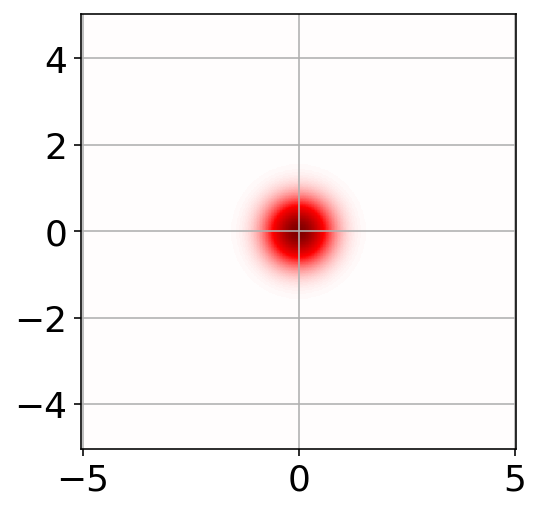

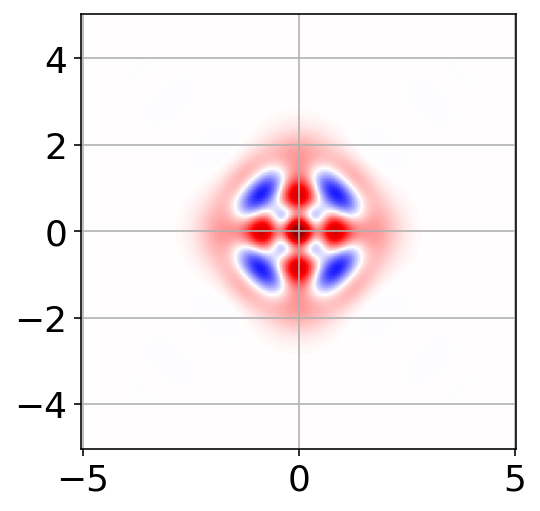

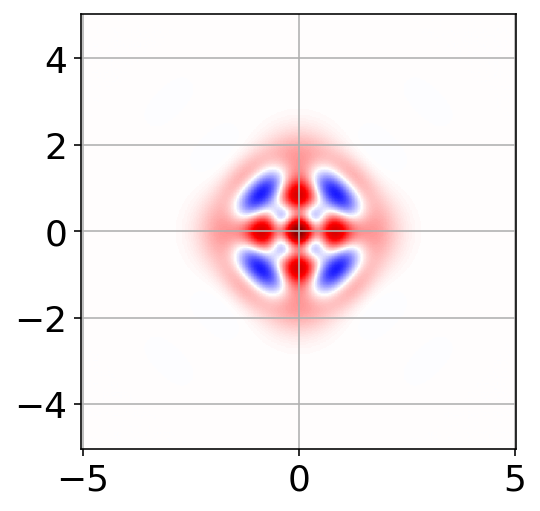

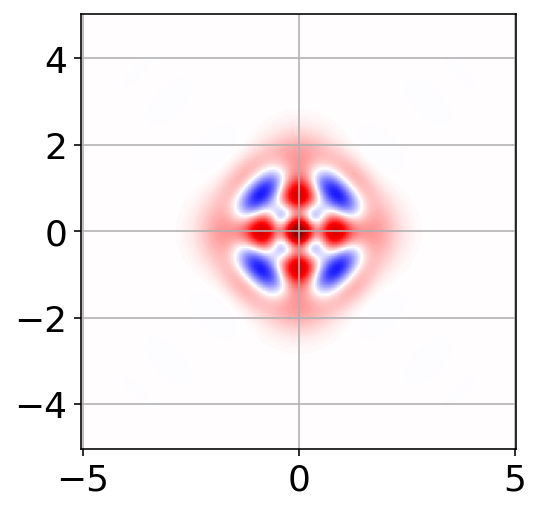

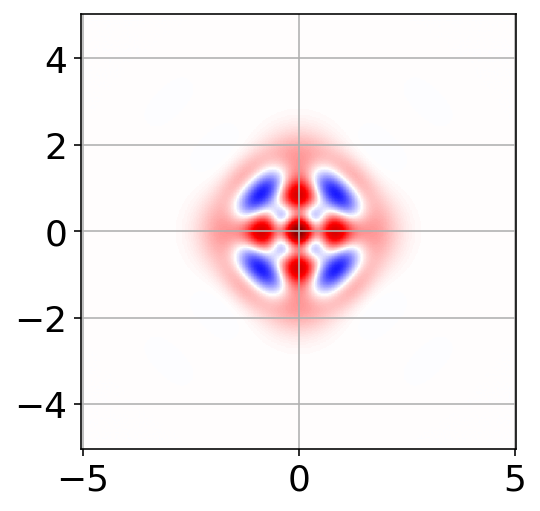

In [54]:
from Bosonic_tools.plotting_tools import plot_wigner
for rho in rhos[::25]:
    plot_wigner(rho.ptrace(0))

In [55]:
# We initialize the gateset here
gate_set_params = {
    'H_static' : H0,
    'H_control' : Hcs,
    'control_delta_t' : 10,
    'interpolation_ratio' : 5,
    'inplace' : False, # true uses less memory, but is slower. Just use false
    'scale' : 1.0, # range of DAC amplitudes for initial random waves
    'pulse_len_ns': 4000,
}
GRAPE_gate_set = GRAPETimeDomain(**gate_set_params)

control_delta_t: 10.000 num_control_pts: 400 pulse_len_ns: 4000.000
              simulation_interpolation_ratio: 5 simulation_delta_t: 2.000 num_simulation_pts: 2000
              fft_pad_length:800 ringup_sigma_ns: 20.000 ringup_len: 10


In [56]:
synth_params = {
    'gateset':GRAPE_gate_set,
    'N_blocks': 400, # note that the length of the pulse is number of control points
    'N_multistart' : 10, #Batch size (number of circuit optimizations to run in parallel)
    'epochs' : 600, #number of epochs before termination
    'epoch_size' : 5, #number of adam steps per epoch
    'learning_rate' : 0.1, #adam learning rate
    'term_fid' : 0.999, #0.995, #terminal fidelitiy
    'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
    'initial_states' : init_states, #qubit tensor oscillator, start in |g> |0>
    'target_states' : target_states, #end in |e> |target>.
    'name' : 'four cat', #name for printing and saving
    'coherent' : True,
    'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}
gatesynth = GateSynthesizer(**synth_params)

In [57]:
#create optimization object. 
#initial params will be randomized upon creation
opt = AdamOptimizer(gatesynth)

#print optimization info. this lives in gatesynth, since we eventually want to fully abstract away the optimizer
gatesynth.best_fidelity()

0.5650507

In [58]:
#run optimizer.
#note the optimizer can be stopped at any time by interrupting the python consle,
#and the optimization results will still be saved and part of the opt object.
#This allows you to stop the optimization whenever you want and still use the result.
# Note that you will not want to use the performance profiler while using 'inplace' mode. You will run out of memory
opt.optimize()#logdir='logs')

Start time: 2022-09-13 22:16:24
 Epoch: 161 / 600 Max Fid: 0.974323 Avg Fid: 0.724425 Max dFid: 0.031347 Avg dFid: 0.004229 Elapsed time: 0:19:50.920861 Expected remaining time: 0:54:07.2935284
 max dFid: 0.031347
dFid stop: 0.000001


 Optimization stopped on keyboard interrupt
N_blocks: 400
optimization_type: state transfer
optimization_masks: {'I0': None, 'Q0': None, 'I1': None, 'Q1': None}
target_unitary: None
expectation_operators: None
target_expectation_values: None
N_multistart: 10
term_fid: 0.999
dfid_stop: 1e-06
learning_rate: 0.1
epoch_size: 5
epochs: 600
name: four cat
filename: None
comment: 
coherent: True
timestamps: ['2022-09-13 19:09:24', '2022-09-13 19:09:44', '2022-09-13 19:11:39', '2022-09-13 19:12:08', '2022-09-13 19:17:31', '2022-09-13 19:19:41', '2022-09-13 22:16:24']
do_prints: True
filename: four cat.h5

Best circuit parameters found:
I0:    tf.Tensor(
[ 0.     +0.j -0.02289+0.j -0.05073+0.j ... -0.01566+0.j -0.01604+0.j
  0.     +0.j], shape=(2000,), dtype=com

'2022-09-13 22:16:24'

In [59]:
import h5py
f = h5py.File('GRAPE Fock 1.h5', 'r')
pulse_obj = f[list(f.keys())[len(list(f.keys())) - 1]] # get the latest key
fids = pulse_obj['fidelities']
# list(f.keys())
pulse_idx = np.argmax(np.amax(fids, axis=0))
controls = []
for k in range(1):
    controls.append(np.array(pulse_obj['I' + str(k)][-1, pulse_idx, :]))
    controls.append(np.array(pulse_obj['Q' + str(k)][-1, pulse_idx, :]))
DAC_time_resolution = 2 # in ns
pulse_len = controls[0].shape[0] * DAC_time_resolution
times = np.arange(pulse_len, step = DAC_time_resolution, dtype=float)
fids[-1, pulse_idx]

0.9991089

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Drive / $\\chi$')

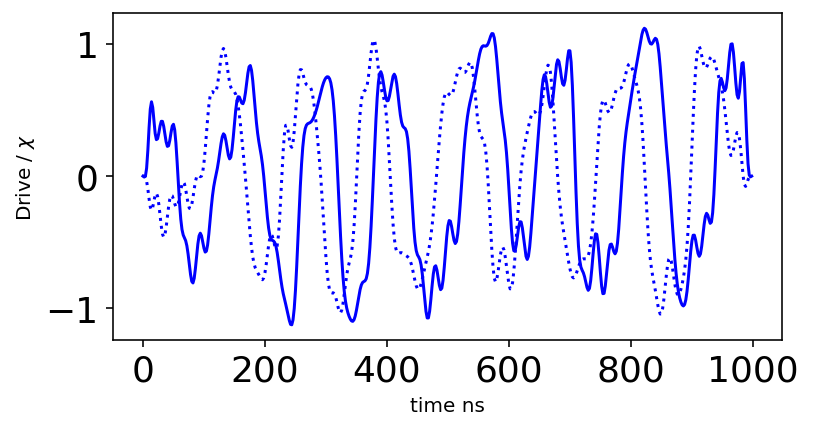

In [60]:
plt.figure(figsize=(6,3))
plt.plot(times, controls[0], 'b-')
plt.plot(times, controls[1], 'b:')
plt.xlabel(r'time ns')
plt.ylabel(r'Drive / $\chi$')

Text(0, 0.5, 'Mag')

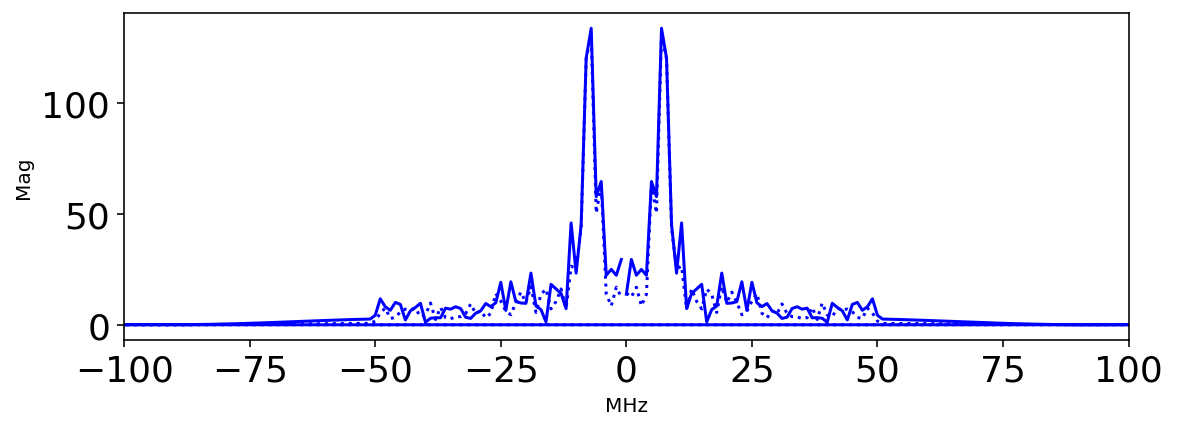

In [61]:
plt.figure(figsize=(9,3))
plt.plot(np.fft.fftfreq(len(controls[0]), DAC_time_resolution) * 1000, np.abs(np.fft.fft(controls[0])), 'b-')
plt.plot(np.fft.fftfreq(len(controls[0]), DAC_time_resolution) * 1000, np.abs(np.fft.fft(controls[1])), 'b:')
plt.xlabel(r'MHz')
plt.xlim(-100, 100)
plt.ylabel(r'Mag')
# plt.yscale('log')